# CoCiP

[Contrail Cirrus Predicition (CoCiP)](https://gmd.copernicus.org/articles/5/543/2012/) model evaluation along a flight trajectory.

## References

- Schumann, U. “A Contrail Cirrus Prediction Model.” Geoscientific Model Development 5, no. 3 (May 3, 2012): 543–80. https://doi.org/10.5194/gmd-5-543-2012.
- Schumann, U., B. Mayer, K. Graf, and H. Mannstein. “A Parametric Radiative Forcing Model for Contrail Cirrus.” Journal of Applied Meteorology and Climatology 51, no. 7 (July 2012): 1391–1406. https://doi.org/10.1175/JAMC-D-11-0242.1.
- Schumann, Ulrich, Robert Baumann, Darrel Baumgardner, Sarah T. Bedka, David P. Duda, Volker Freudenthaler, Jean-Francois Gayet, et al. 2017. “Properties of Individual Contrails: A Compilation of Observations and Some Comparisons.” Atmospheric Chemistry and Physics 17 (1): 403–38. https://doi.org/10.5194/acp-17-403-2017.
- Teoh, Roger, Ulrich Schumann, Arnab Majumdar, and Marc E. J. Stettler. “Mitigating the Climate Forcing of Aircraft Contrails by Small-Scale Diversions and Technology Adoption.” Environmental Science & Technology 54, no. 5 (March 3, 2020): 2941–50. https://doi.org/10.1021/acs.est.9b05608.
- Teoh, Roger, Ulrich Schumann, Edward Gryspeerdt, Marc Shapiro, Jarlath Molloy, George Koudis, Christiane Voigt, and Marc E. J. Stettler. 2022. “Aviation Contrail Climate Effects in the North Atlantic from 2016 to 2021.” Atmospheric Chemistry and Physics 22 (16): 10919–35. https://doi.org/10.5194/acp-22-10919-2022.
- Teoh, Roger, Ulrich Schumann, Christiane Voigt, Tobias Schripp, Marc Shapiro, Zebediah Engberg, Jarlath Molloy, George Koudis, and Marc E. J. Stettler. 2022. “Targeted Use of Sustainable Aviation Fuel to Maximize Climate Benefits.” Environmental Science & Technology, November. https://doi.org/10.1021/acs.est.2c05781.



In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pycontrails import Flight, MetDataset
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import (
    Cocip,
    flight_waypoint_summary_statistics,
    contrail_flight_summary_statistics,
    natural_cirrus_properties_to_hi_res_grid,
)
from pycontrails.models.humidity_scaling import ConstantHumidityScaling

plt.rcParams["figure.figsize"] = (10, 6)

## Download meteorology data from ECMWF

This demo uses [ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) via the [Copernicus Data Store (CDS)](https://cds.climate.copernicus.eu/) for met data.
This requires account with [Copernicus Data Portal](https://cds.climate.copernicus.eu/cdsapp#!/home) and  local `~/.cdsapirc` file with credentials.

> Note this will download ~1 GB of meteorology data to your computer

In [2]:
time_bounds = ("2022-03-01 00:00:00", "2022-03-01 23:00:00")
pressure_levels = (300, 250, 200)

In [3]:
era5pl = ERA5(
    time=time_bounds,
    variables=Cocip.met_variables + Cocip.optional_met_variables,
    pressure_levels=pressure_levels,
)
era5sl = ERA5(time=time_bounds, variables=Cocip.rad_variables)

In [4]:
# download data from ERA5 (or open from cache)
met = era5pl.open_metdataset()
rad = era5sl.open_metdataset()

## Load Flight Data

`Flight` can be loaded from CSV, parquet, or created from a pandas DataFrame

In [5]:
# demo synthetic flight
flight_attrs = {
    "flight_id": "test",
    # set constants along flight path
    "true_airspeed": 226.099920796651,  # true airspeed, m/s
    "thrust": 0.22,  # thrust_setting
    "nvpm_ei_n": 1.897462e15,  # non-volatile emissions index
    "aircraft_type": "E190",
    "wingspan": 48,  # m
    "n_engine": 2,
}

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(-25, -40, 100)
df["latitude"] = np.linspace(34, 40, 100)
df["altitude"] = np.linspace(10900, 10900, 100)
df["engine_efficiency"] = np.linspace(0.34, 0.35, 100)
df["fuel_flow"] = np.linspace(2.1, 2.4, 100)  # kg/s
df["aircraft_mass"] = np.linspace(154445, 154345, 100)  # kg
df["time"] = pd.date_range("2022-03-01T00:15:00", "2022-03-01T02:30:00", periods=100)

flight = Flight(df, attrs=flight_attrs)
flight

Flight [7 keys x 100 length, 8 attributes]
	Keys: longitude, latitude, altitude, engine_efficiency, fuel_flow, ..., time
	Attributes:
	time                [2022-03-01 00:15:00, 2022-03-01 02:30:00]
	longitude           [-40.0, -25.0]
	latitude            [34.0, 40.0]
	altitude            [10900.0, 10900.0]
	flight_id           test
	true_airspeed       226.099920796651
	thrust              0.22
	nvpm_ei_n           1897462000000000.0
	aircraft_type       E190
	wingspan            48
	n_engine            2
	crs                 EPSG:4326

## Run `Cocip` on a single flight

In this first example, the `Flight` has aircraft performance (i.e. `nvpm_ei_n`) hardcoded into the data as constants. This data is assumed to be constant at every flight waypoint. 

> **Caveat**

> - When the `Cocip` model is run on one `Flight`, the default behavior is to **downselect the meteorology**
to a region surrounding the flight and **process the meteorology**  (i.e. humidity scaling, `tau_cirrus`) on the smaller domain. The implications of this processing is each instance of a single-flight `Cocip` model should *only be run once*.
> - We ignore the warning here about humidity scaling for ECMWF data sources 

In [6]:
params = {
    "dt_integration": np.timedelta64(10, "m"),
    # The humidity_scaling parameter is only used for ECMWF ERA5 data
    # based on Teoh 2020 and Teoh 2022 - https://acp.copernicus.org/preprints/acp-2022-169/acp-2022-169.pdf
    # Here we use an example of constantly scaling the humidity value by 0.99
    "humidity_scaling": ConstantHumidityScaling(rhi_adj=0.99),
}
cocip = Cocip(met=met, rad=rad, params=params)

In [7]:
output_flight = cocip.eval(source=flight)

## Explore Flight Output

The `output_flight` object holds roughly 50 variables of interest. The energy forcing `ef` field is a primary model output. Waypoints not producing persistent contrails are assigned an `ef` value of 0.

In [8]:
df = output_flight.dataframe
df.head()

,waypoint,longitude,latitude,altitude,engine_efficiency,fuel_flow,aircraft_mass,flight_id,level,air_pressure,...,ef,contrail_age,sdr_mean,rsr_mean,olr_mean,rf_sw_mean,rf_lw_mean,rf_net_mean,cocip,time
0,0,-25.000000,34.000000,10900.0,0.340000,2.100000,154445.000000,test,229.908663,22990.866319,...,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-03-01 00:15:00.000000000
1,1,-25.151515,34.060606,10900.0,0.340101,2.103030,154443.989899,test,229.908663,22990.866319,...,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-03-01 00:16:21.818181818
2,2,-25.303030,34.121212,10900.0,0.340202,2.106061,154442.979798,test,229.908663,22990.866319,...,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-03-01 00:17:43.636363636
3,3,-25.454545,34.181818,10900.0,0.340303,2.109091,154441.969697,test,229.908663,22990.866319,...,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-03-01 00:19:05.454545454
4,4,-25.606061,34.242424,10900.0,0.340404,2.112121,154440.959596,test,229.908663,22990.866319,...,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-03-01 00:20:27.272727272


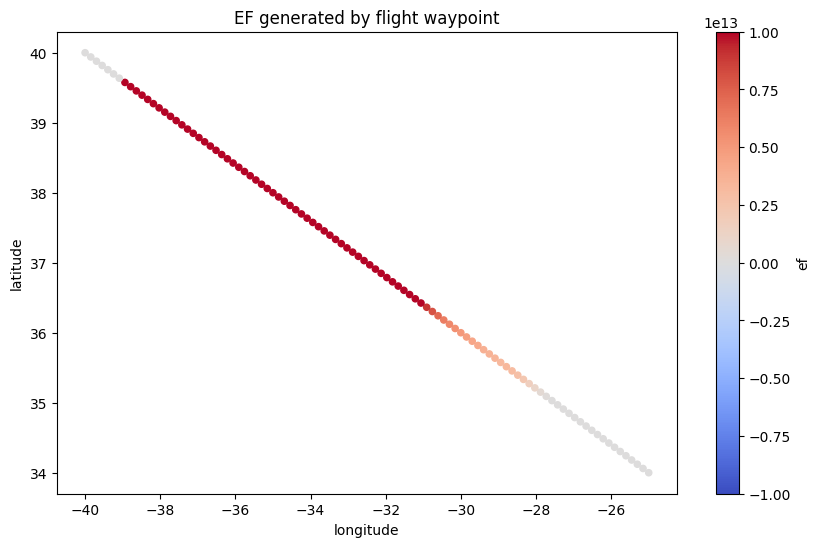

In [9]:
df.plot.scatter(
    x="longitude",
    y="latitude",
    c="ef",
    cmap="coolwarm",
    vmin=-1e13,
    vmax=1e13,
    title="EF generated by flight waypoint",
);

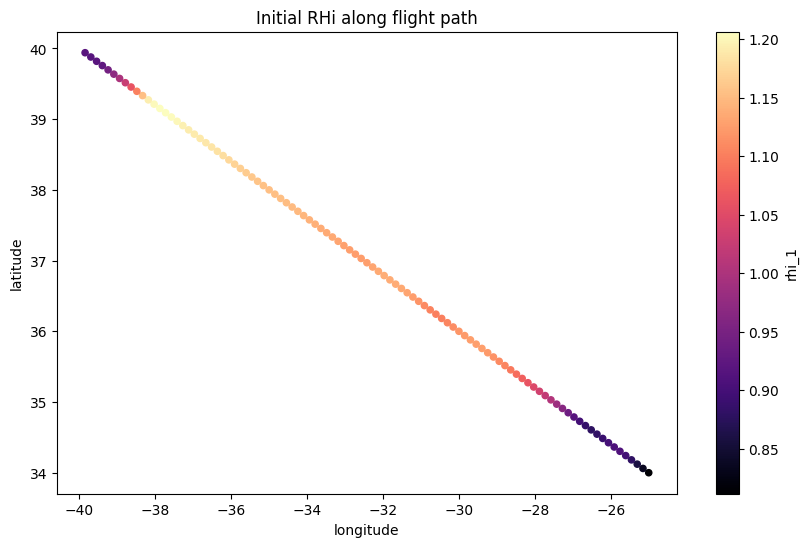

In [10]:
df.plot.scatter(
    x="longitude",
    y="latitude",
    c="rhi_1",
    cmap="magma",
    title="Initial RHi along flight path",
);

## Explore Contrail Output

- The `cocip.contrail` attribute is a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) representation of the contrail waypoints.
- The `cocip.contrail_dataset` attribute is a [`xarray.Dataset`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) representation of the contrail waypoints.

In [11]:
contrail = cocip.contrail
contrail.head()

,waypoint,flight_id,formation_time,time,age,longitude,latitude,altitude,level,continuous,...,tau_contrail,dn_dt_agg,dn_dt_turb,rf_sw,rf_lw,rf_net,persistent,ef,timestep,age_hours
0,16,test,2022-03-01 00:36:49.090909090,2022-03-01 00:40:00,0 days 00:03:10.909090910,-27.378231,34.922638,10844.400260,231.925490,True,...,0.011010,1.234910e-20,0.000043,0.0,0.068196,0.068196,True,6.689890e+08,2,0.053030
1,17,test,2022-03-01 00:38:10.909090909,2022-03-01 00:40:00,0 days 00:01:49.090909091,-27.548940,35.003593,10844.712824,231.914112,True,...,0.129143,1.869473e-19,0.000069,0.0,1.562847,1.562847,True,8.577679e+08,2,0.030303
2,18,test,2022-03-01 00:39:32.727272727,2022-03-01 00:40:00,0 days 00:00:00,-27.720435,35.084279,10844.521456,231.921078,False,...,0.332402,3.208285e-19,0.000231,0.0,3.894476,3.894476,True,0.000000e+00,2,0.000000
0,17,test,2022-03-01 00:38:10.909090909,2022-03-01 00:50:00,0 days 00:11:49.090909091,-27.402288,34.856294,10844.941285,231.905796,True,...,0.029814,8.479717e-20,0.000022,0.0,0.461144,0.461144,True,6.440944e+09,3,0.196970
1,18,test,2022-03-01 00:39:32.727272727,2022-03-01 00:50:00,0 days 00:10:27.272727273,-27.570210,34.938334,10846.431039,231.851574,True,...,0.041419,2.521271e-19,0.000024,0.0,0.798674,0.798674,True,8.482594e+09,3,0.174242


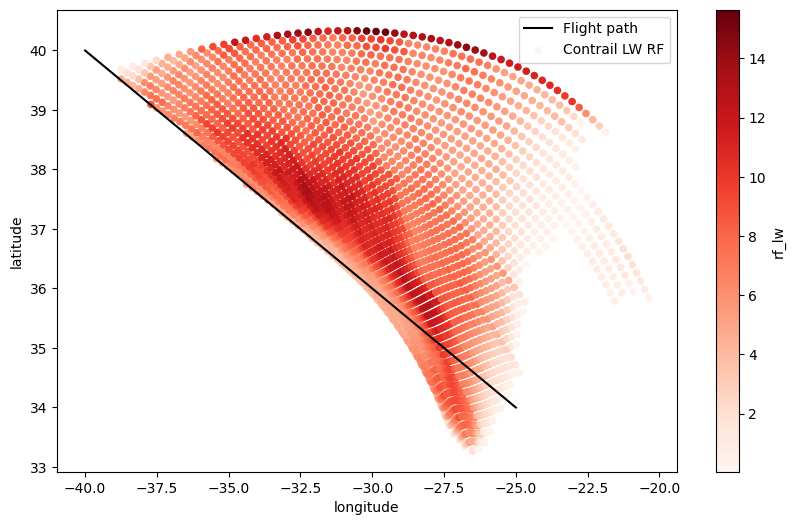

In [12]:
ax = plt.axes()

cocip.source.dataframe.plot(
    "longitude",
    "latitude",
    color="k",
    ax=ax,
    label="Flight path",
)
cocip.contrail.plot.scatter(
    "longitude",
    "latitude",
    c="rf_lw",
    cmap="Reds",
    ax=ax,
    label="Contrail LW RF",
)
ax.legend();

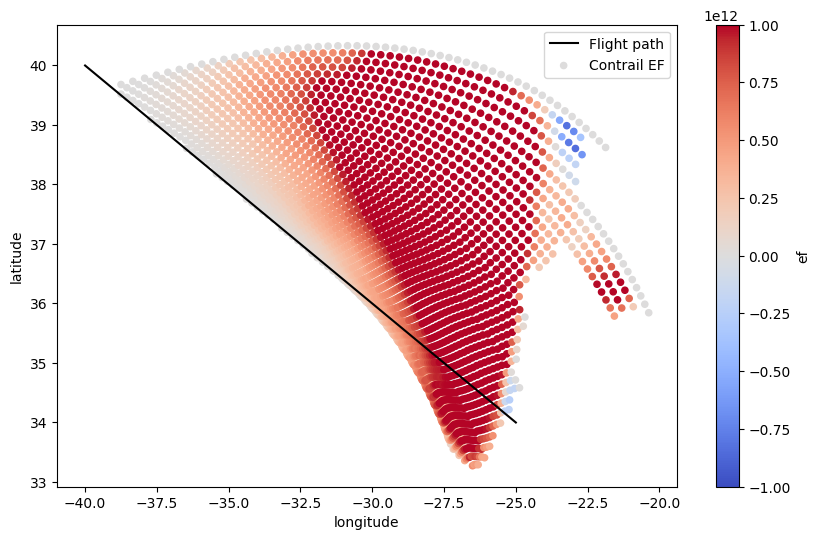

In [13]:
ax = plt.axes()

cocip.source.dataframe.plot(
    "longitude",
    "latitude",
    color="k",
    ax=ax,
    label="Flight path",
)
cocip.contrail.plot.scatter(
    "longitude",
    "latitude",
    c="ef",
    cmap="coolwarm",
    vmin=-1e12,
    vmax=1e12,
    ax=ax,
    label="Contrail EF",
)
ax.legend();

## Explore Flight Summary

A curated set of statistics available after a `Flight` has been run through `eval`

In [14]:
# flight_statistics = cocip.output_flight_statistics()
# flight_statistics

waypoint_summary = flight_waypoint_summary_statistics(cocip.source, cocip.contrail)
flight_summary = contrail_flight_summary_statistics(waypoint_summary)
flight_summary

flight_id                                            test
total_flight_distance_flown                1489372.551665
total_contrails_formed                     1489372.551665
total_persistent_contrails_formed          1489372.551665
mean_lifetime_contrail_altitude              10912.994446
mean_lifetime_rhi                                 1.11605
mean_lifetime_n_ice_per_m            8832796539379.113281
mean_lifetime_r_ice_vol                          0.000006
mean_lifetime_contrail_width                 15992.558801
mean_lifetime_contrail_depth                   555.436282
mean_lifetime_tau_contrail                       0.174001
mean_lifetime_tau_cirrus                         0.256965
mean_contrail_lifetime                            5.42803
max_contrail_lifetime                           10.583333
mean_lifetime_rf_sw                             -0.097779
mean_lifetime_rf_lw                              5.612927
mean_lifetime_rf_net                             5.515148
total_energy_f

## Run Cocip on Multiple Flights

Run multiple `Flight` inputs on a single set of meteorology.

For this demo, we'll copy the original flight and tweak its longitude and latitudes values.

In [15]:
flights = []
for i in range(10):
    fl = flight.copy()
    fl.attrs.update(flight_id=f"test-{i:02d}")
    fl.update(latitude=flight["latitude"] + i)
    fl.update(longitude=flight["longitude"] + i)
    flights.append(fl)

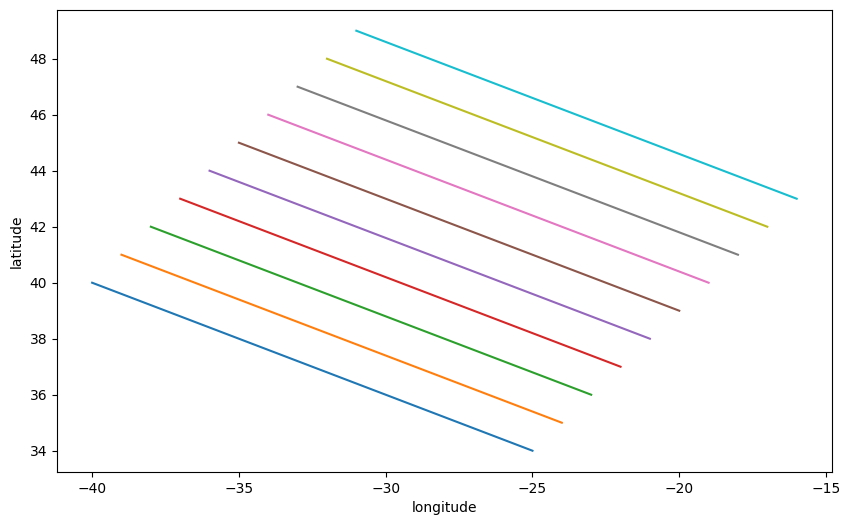

In [16]:
# Visualize the fleet of 10 flights
ax = plt.axes()
for fl in flights:
    fl.plot(ax=ax)

Run the `Cocip` model over a `list[Flight]` objects

In [17]:
cocip = Cocip(
    met=met,
    rad=rad,
    process_emissions=False,
    humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99),
)

# returns list of Flight outputs
output_flights = cocip.eval(source=flights)

In [18]:
# print EF for each flight
for fl in output_flights:
    print(f"{fl.attrs['flight_id']}: {np.sum(fl['ef'])}")

test-00: 2220315061685167.5
test-01: 1615865274388206.0
test-02: 1374262685441009.5
test-03: 716636088944872.0
test-04: 784209868637.4282
test-05: 2031202635.3101897
test-06: 0.0
test-07: 0.0
test-08: 0.0
test-09: 0.0


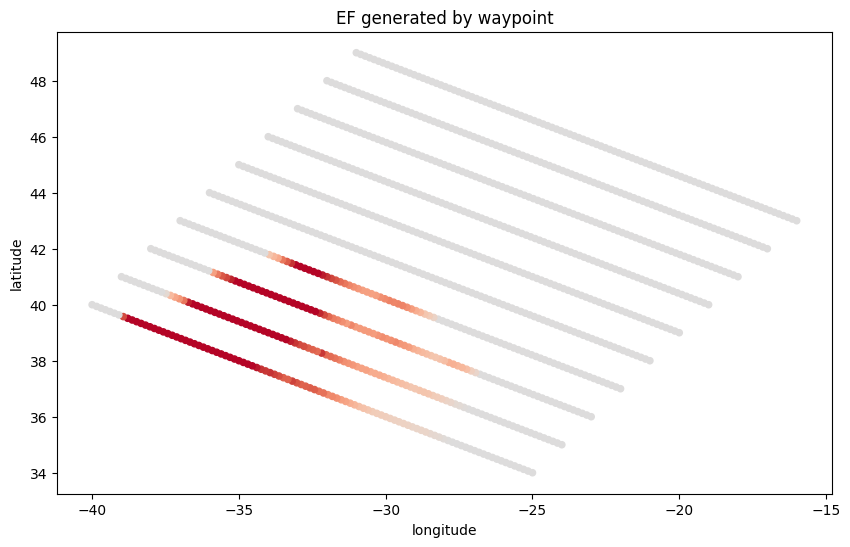

In [19]:
# Visualize the "ef" of each flight
ax = plt.axes()
for fl in output_flights:
    fl.dataframe.plot.scatter(
        x="longitude",
        y="latitude",
        c="ef",
        cmap="coolwarm",
        vmin=-3e13,
        vmax=3e13,
        title="EF generated by waypoint",
        ax=ax,
        colorbar=False,
    );

## Use the Poll-Schumann aircraft performance model

First create a Flight that does not have emissions data associated:

In [20]:
# demo synthetic flight
flight_attrs = {
    "flight_id": "test-ps-model",
    "aircraft_type": "E195",
}

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(-40, -55, 100)
df["latitude"] = np.linspace(38, 45, 100)
df["altitude"] = np.linspace(10900, 10900, 100)
df["time"] = pd.date_range("2022-03-01T00:15:00", "2022-03-01T02:30:00", periods=100)
fl = Flight(data=df, attrs=flight_attrs)

In [21]:
from pycontrails.models.ps_model import PSModel

In [22]:
cocip = Cocip(
    met=met,
    rad=rad,
    humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99),
    aircraft_performance=PSModel(),
)

output_flight = cocip.eval(source=fl)

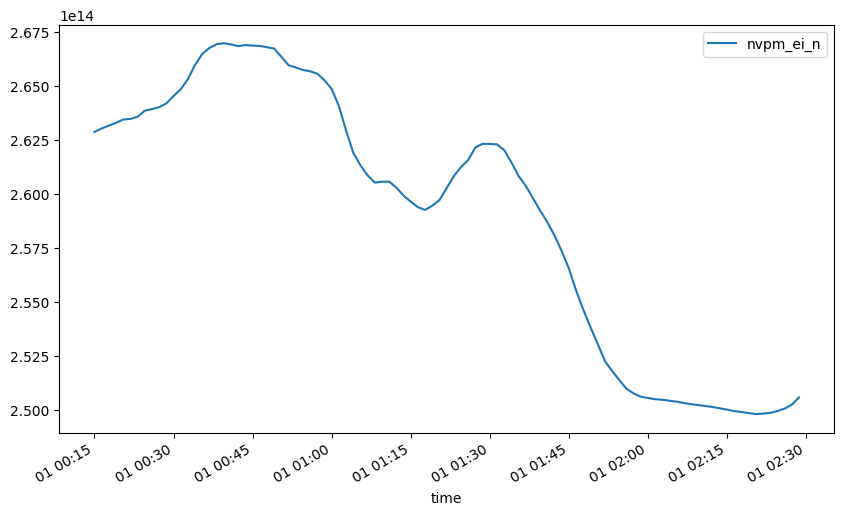

In [23]:
output_flight.dataframe.plot(x="time", y="nvpm_ei_n");

## Output contrail cirrus optical depth

> Note this is only a preliminary implementation and will be changed in the future

The example below uses the contrail cirrus output from 1 flight, but the `df_contrails` input can include 
contrail cirrus from multiple flights.

To run multiple flights, concatenate `Cocip.contrail` outputs from multiple flights and feed in to `grid_cirrus.<>` methods as `df_contrails`.
Unique `flight_id` column will have to be added to the `Cocip.contrail` output before concatenation.

In [24]:
# demo synthetic flight
flight_attrs = {
    "flight_id": "test",
    "true_airspeed": 226.099920796651,  # true airspeed, m/s
    "thrust": 0.22,  # thrust_setting
    "nvpm_ei_n": 1.897462e15,
    "aircraft_type": "E190",
    "wingspan": 48,
    "n_engine": 2,
}

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(-40, -55, 100)
df["latitude"] = np.linspace(38, 45, 100)
df["altitude"] = np.linspace(10900, 10900, 100)
df["engine_efficiency"] = np.linspace(0.34, 0.35, 100)  # ope
df["fuel_flow"] = np.linspace(2.1, 2.4, 100)  # kg/s
df["aircraft_mass"] = np.linspace(154445, 154345, 100)  # kg
df["time"] = pd.date_range("2022-03-01T00:15:00", "2022-03-01T02:30:00", periods=100)
fl = Flight(data=df, attrs=flight_attrs)

In [25]:
# run model
cocip = Cocip(
    met=met,
    rad=rad,
    process_emissions=False,
    humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99),
)
output_flight = cocip.eval(source=fl)

In [26]:
# get dataframe of contrail waypoints
df_contrails = cocip.contrail
df_contrails["flight_id"] = cocip.source.attrs["flight_id"]

In [27]:
w = df_contrails["longitude"].min()
e = df_contrails["longitude"].max()
s = df_contrails["latitude"].min()
n = df_contrails["latitude"].max()
bbox = (w, s, e, n)

met_bbox = MetDataset(met.data.isel(time=[0])).downselect(bbox)

In [28]:
ds_cirrus = natural_cirrus_properties_to_hi_res_grid(met_bbox)

/Users/zebengberg/contrails/pycontrails/pycontrails/core/met.py:745: UserWarning: Overwriting data in keys `['tau_cirrus']`. Use `.update(...)` to suppress warning.
  warnings.warn(


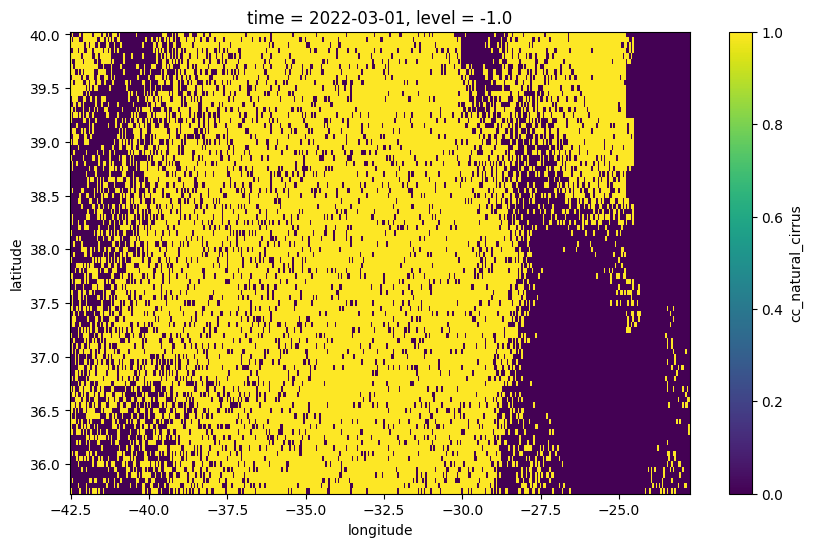

In [29]:
ds_cirrus["cc_natural_cirrus"].data.squeeze().plot(x="longitude", y="latitude");

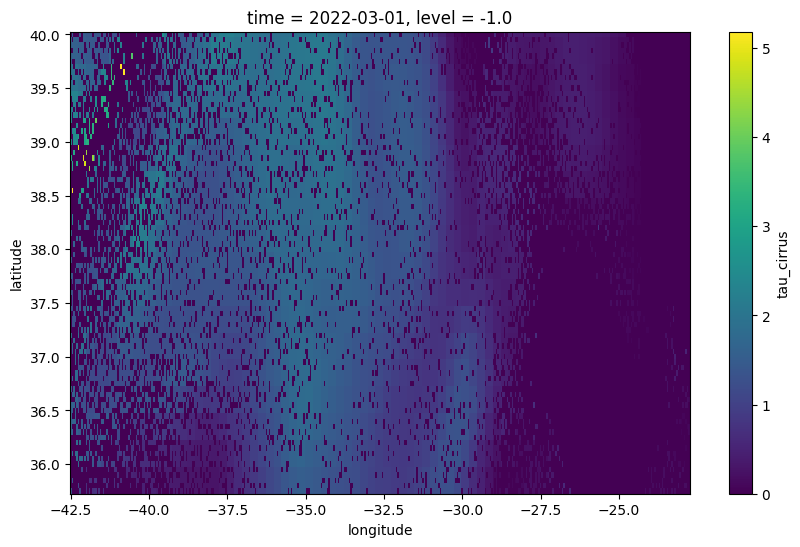

In [30]:
ds_cirrus["tau_cirrus"].data.squeeze().plot(x="longitude", y="latitude");